In [119]:
# city = 'Utrecht'
# city_str = 'Utrecht, Netherlands'
# dist = 6500

# city = 'Winterswijk'
# city_str = 'Winterswijk, Netherlands'
# dist = 10000

city = 'Manhattan'
city_str = 'Union Square, New York, United States'
dist = 5000

# city = 'Amsterdam'
# city_str = 'Meeuwenlaan 88, Amsterdam, Netherlands'
# dist = 15000

In [120]:
filepath=f"graphs/{city}.graph.graphml"
# ox.save_graph_geopackage(G, filepath=filepath)
G = ox.load_graphml(filepath=filepath)

with open(f'data/escape_nodes_{city}.pkl', 'rb') as f:
    escape_nodes = pickle.load(f)
    
with open(f'data/fugitive_start_{city}.pkl', 'rb') as f:
    fugitive_start = pickle.load(f)

if city != 'Winterswijk':    
    with open(f'data/cameras_{city}.pkl', 'rb') as f:
        cameras = pickle.load(f)
elif city == 'Winterswijk':
    cameras = []

In [121]:
len(escape_nodes)

21

In [122]:
# escape_nodes_filtered = []
# for escape_node in escape_nodes:
#     if G.has_node(escape_node):
#         escape_nodes_filtered.append(escape_node)
# 
# with open('data/escape_nodes_Utrecht_filtered.pkl', 'wb') as f: 
#     pickle.dump(escape_nodes_filtered, f)

In [123]:
# escape_nodes = escape_nodes_filtered.copy()

In [124]:
def draw_edges(graph):
    edges_fugitive = []

    # for i_r, route_time in enumerate(fugitive_routes):
    #     route = list(route_time.values())
    #     for i, node in enumerate(route):
    #         if i ==0:
    #             continue
    #         else:
    #             edges_fugitive1 = [(route[i], route[i-1])]
    #             edges_fugitive2 = [(route[i-1], route[i])]
    #             edges_fugitive.extend(tuple(edges_fugitive1))
    #             edges_fugitive.extend(tuple(edges_fugitive2))

    edge_colormap = ['lightgray'] * len(graph.edges())
    edge_weightmap = [1] * len(graph.edges())
    for index, edge in enumerate(graph.edges()):
        if edge in edges_fugitive:
            edge_colormap[index] = 'tab:orange'
            edge_weightmap[index] = 2

    return edge_colormap, edge_weightmap

In [125]:
def draw_nodes(G, fugitive_start, cameras, trafficlights, roundabouts, tunnels, bridges, escape_nodes):
    node_size = []
    node_color = []
    for node in G.nodes:
        if node == fugitive_start:
            node_size.append(40)
            node_color.append('tab:orange')
        elif node in escape_nodes:
            node_size.append(40)
            node_color.append('tab:red')
        elif node in cameras:
            node_size.append(10)
            node_color.append('tab:green')      
        elif node in trafficlights:
            node_size.append(10)
            node_color.append('purple')  
        elif node in roundabouts:
            node_size.append(10)
            node_color.append('gold')    
        elif node in tunnels:
            node_size.append(10)
            node_color.append('aqua')   
        elif node in bridges:
            node_size.append(10)
            node_color.append('royalblue')   
        else:
            node_size.append(0)
            node_color.append('lightgray')
    return node_size, node_color

In [126]:
from matplotlib.lines import Line2D

def show_graph(G, escape_nodes, fugitive_start, cameras, trafficlights, roundabouts, bridges, tunnels, save=False):
    # filepath=f"graphs/FLEE/Graph_FLEE.graph.graphml"
    # G = ox.load_graphml(filepath=filepath)

    edge_colormap, edge_weightmap = draw_edges(G)
    node_size, node_color = draw_nodes(G, fugitive_start, cameras, trafficlights, roundabouts, tunnels, bridges, escape_nodes)

    fig, ax = ox.plot_graph(
                G, bgcolor="white", node_color=node_color, node_size=node_size, edge_linewidth=edge_weightmap, edge_color=edge_colormap,
                )
    if save:

        custom_lines = [Line2D([0], [0], color='tab:orange', marker='o', markersize=10, linestyle=''),
                        Line2D([0], [0], color='tab:red', marker='o', markersize=10, linestyle=''),
                        Line2D([0], [0], color='tab:green', marker='o', markersize=10, linestyle=''),
                        Line2D([0], [0], color='purple', marker='o', markersize=10, linestyle=''),
                        Line2D([0], [0], color='gold', marker='o', markersize=10, linestyle=''),
                        Line2D([0], [0], color='aqua', marker='o', markersize=10, linestyle=''),
                        Line2D([0], [0], color='royalblue', marker='o', markersize=10, linestyle=''),
                        ]
        labels = ['start fugitive', 'escape node', 'camera', 'traffic light', 'roundabout', 'tunnel', 'bridge']
        ax.legend(custom_lines, labels, bbox_to_anchor=(1.1, 1.05))
        fig.savefig(f'graphs/{city}_features.png', bbox_inches='tight', dpi=300)

In [127]:
roundabouts = []
for u,v, data in G.edges(data=True): 
    if 'junction' in data.keys():
        if data['junction'] == 'roundabout':
            roundabouts.append(u)
            roundabouts.append(v)
            
roundabouts = np.unique(roundabouts)

In [128]:
import networkx as nx
import osmnx as ox

useful_tags_path = ['bridge', 'tunnel', 'oneway', 'lanes', 'ref', 'name', 'length',
                    'highway', 'maxspeed', 'service', 'access', 'area', 'name'
                    'landuse', 'width', 'est_width', 'junction', 'surface', 
                    'traffic_signals', 'crossing']

ox.settings.useful_tags_way=useful_tags_path

def generate_streetnetwork(city_str, dist):
    """
    Load a network from OSMNX which will be used for the simulation runs. The generated network is from Rotterdam.
    Returns
    -------
    G: network MultiGraph
        Network Graph with different attributes:
            Nodes and Edges with LineString with coordinates,
            Edges have properties Speed, Travel time, Length.

    """
   
    cf = '["highway"~"motorway|motorway_link|trunk|trunk_link|primary|secondary|tertiary|residential"]'
    
    if city == 'Amsterdam': 
        print('hey')
        cf = '[primary|secondary"]'
        cf = '["highway"~"motorway|motorway_link|trunk|trunk_link|primary|secondary"]'
    ox.settings.log_console=True
    ox.settings.use_cache=True

    # download street network data from OSM and construct a MultiDiGraph model
    G = ox.graph_from_address(city_str, dist=dist, network_type='drive', simplify=False, custom_filter=cf)

    return G

G_notsimplified=generate_streetnetwork(city_str, dist)

if city == 'Manhattan': 
    G_notsimplified = G.copy()

trafficlight_locs = []
for u, data in G_notsimplified.nodes(data=True): 
    if 'traffic_signals' in data.keys():
        trafficlight_locs.append(data)
    elif 'highway' in data.keys():
        if data['highway'] == 'traffic_signals':
            trafficlight_locs.append(data)
    elif 'crossing' in data.keys():
        if data['crossing'] == 'traffic_signals':
            trafficlight_locs.append(data)

In [129]:
len(trafficlight_locs)

1749

In [130]:
# trafficlight_locs = []
# for u, data in G.nodes(data=True): 
#     if 'traffic_signals' in data.keys():
#         trafficlight_locs.append(data)
#     elif 'highway' in data.keys():
#         if data['highway'] == 'traffic_signals':
#             trafficlight_locs.append(data)
#     elif 'crossing' in data.keys():
#         if data['crossing'] == 'traffic_signals':
#             trafficlight_locs.append(data)

In [131]:
trafficlights = []
for trafficlight in trafficlight_locs:
    closest_node = ox.nearest_nodes(G, trafficlight['x'], trafficlight['y'])
    trafficlights.append(closest_node)
    
trafficlights = np.unique(trafficlights)
len(trafficlights)

1749

In [132]:
tunnels = []
for u, v, data in G.edges(data=True): 
    if 'tunnel' in data.keys():
        tunnels.append(u)
        tunnels.append(v)
            
tunnels = np.unique(tunnels)

In [133]:
bridges = []
for u, v, data in G.edges(data=True): 
    if 'bridge' in data.keys():
        if data['bridge'] == 'movable':
            bridges.append(u)
            bridges.append(v)
            
bridges = np.unique(bridges)
bridges

array([], dtype=float64)

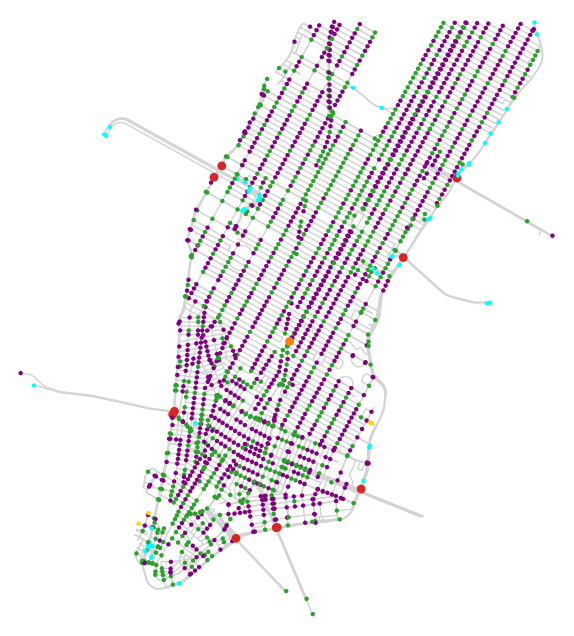

In [134]:
show_graph(G, escape_nodes, fugitive_start, cameras, trafficlights, roundabouts, bridges, tunnels, save=True)

Loop through all edges in graph. If u/v has camera/traffic light/roundabout/etc, add time to travel_time of edge. e.g. 30 sec for camera, 10 sec for traffic light, 5 for roundabout (bc multiple nodes)?

In [97]:
camera_extra_time = 0
roundabout_extra_time = 5
trafficlight_extra_time = 20
tunnel_extra_time = 10
bridge_extra_time = 5

travel_time_dict = {}
for u, v, data in G.edges(data=True): 
    travel_time_adj = data['travel_time']
    
    # number of lanes
    if 'lanes' in data.keys():
        if '1' in data['lanes']:
            travel_time_adj += data['travel_time'] * 0.2
        elif '2' in data['lanes']:
            pass
        else:
            travel_time_adj -= data['travel_time'] * 0.2
        
    # speed limit
    if data['speed_kph'] <= 30:
        travel_time_adj += data['travel_time'] * 0.2
    elif data['speed_kph'] <= 50:
        pass
    elif data['speed_kph'] <= 80:
        travel_time_adj -= data['travel_time'] * 0.1
    elif data['speed_kph'] >= 80:
        travel_time_adj -= data['travel_time'] * 0.2
    
    if data['highway'] in ['motorway', 'trunk', 'primary']: 
        travel_time_adj += 40
    
    if u in cameras:
        travel_time_adj += camera_extra_time
    if u in trafficlights:
        travel_time_adj += trafficlight_extra_time
    if u in roundabouts:
        travel_time_adj += roundabout_extra_time
    if u in tunnels:
        travel_time_adj += tunnel_extra_time
    if u in bridges:
        travel_time_adj += bridge_extra_time
    
    if v in cameras:
        travel_time_adj += camera_extra_time
    if v in trafficlights:
        travel_time_adj += trafficlight_extra_time
    if v in roundabouts:
        travel_time_adj += roundabout_extra_time
    if v in tunnels:
        travel_time_adj += tunnel_extra_time
    if v in bridges:
        travel_time_adj += bridge_extra_time
    
    travel_time_dict[(u, v, 0)] = float(travel_time_adj)

nx.set_edge_attributes(G, travel_time_dict, "travel_time_adj")

In [98]:
# escape_routes = []
# for escape_node in escape_nodes: 
#     try:
#         path = nx.shortest_path(G, fugitive_start, escape_node, 'travel_time_adj')
#         # [escape_routes.append(path) for path in nx.all_simple_paths(G, fugitive_start, escape_node)]
#         escape_routes.append(path)
#     except:
#         continue

In [99]:
len(escape_nodes)

148

In [100]:
route_fugitive = []
while len(route_fugitive) < 1000:
    for escape_node in escape_nodes:
        try:
            path = nx.shortest_path(G, fugitive_start, escape_node, 'travel_time_adj')
            # [escape_routes.append(path) for path in nx.all_simple_paths(G, fugitive_start, escape_node)]
            route_fugitive.append(path)
        except:
            continue

In [101]:
len(route_fugitive)

1020

In [102]:
with open(f'data/escape_routes_{city}_hot.pkl', 'wb') as f: 
    pickle.dump(route_fugitive, f)

In [103]:
filepath=f"graphs/{city}_prepped_hot.graph.graphml"
# ox.save_graph_geopackage(G, filepath=filepath)
ox.save_graphml(G,filepath)

In [104]:
# # # nx.draw_networkx_edges(G,edgelist=path_edges,edge_color='r',width=10)
# node_size, node_color = draw_nodes(G, fugitive_start, [], [], [], [], [], escape_nodes)
# edge_colormap, edge_weightmap = draw_edges(G)
# 
# fig, ax = ox.plot_graph_routes(G, route_fugitive, route_alphas=0.05,
#                                route_linewidths=1, orig_dest_size=0,
#                                edge_linewidth=edge_weightmap, edge_color=edge_colormap,
#                                node_color=node_color, node_size=node_size, 
#                                bgcolor="white", )
# 
# fig.savefig(f'{city}_hot.png', bbox_inches='tight', dpi=300)


## put shortest path into ABM and add noise where they deviate from shortest path

In [105]:
# jitter = 0.02
# 
# # nx.draw_networkx_edges(G,edgelist=path_edges,edge_color='r',width=10)
# node_size, node_color = draw_nodes(G, fugitive_start, cameras, trafficlights, roundabouts, tunnels, bridges, escape_nodes)
# edge_colormap, edge_weightmap = draw_edges(G)
# 
# with open(f'data/results_routes_{city}_jitter{jitter}.pkl', 'rb') as f:
#     results_routes = pickle.load(f)
# 
# results_routes = [list(route.values()) for route in results_routes]
# 
# fig, ax = ox.plot_graph_routes(G, results_routes, 
#                                route_linewidths=1, route_alpha=0.05,
#                                edge_linewidth=edge_weightmap, edge_color=edge_colormap,
#                                node_color=node_color, node_size=node_size, 
#                                bgcolor="white", 
#                                orig_dest_size=30,
#                                # orig_dest_node_color=['tab:orange', 'tab:red']*len(results_routes),
#                                )
# 
# fig.savefig(f'{city}_cool_noise_jitter{jitter}.png', bbox_inches='tight', dpi=300)
# #add ANPR cameras